<b>¡Hola Carlos!</b>

Mi nombre es Alejandro Abia y tengo el gusto de revisar tu proyecto.

A continuación, encontrarás mis comentarios en celdas pintadas de tres colores (verde, amarillo y rojo), a manera de semáforo. Por favor, <b>no las borres ni muevas de posición</b> mientras dure el proceso de revisión.

<div class="alert alert-block alert-success">
<b>Éxito</b> <a class="tocSkip"></a>
En celdas verdes encontrarás comentarios en relación a tus aciertos y fortalezas.
</div>
<div class="alert alert-block alert-warning">
<b>Atención</b> <a class="tocSkip"></a>
Utilizaré el color amarillo para llamar tu atención, expresar algo importante o compartirte alguna idea de valor.
</div>
<div class="alert alert-block alert-danger">
<b>A resolver</b> <a class="tocSkip"></a>
En rojo emitiré aquellos puntos que podrían impedir que el proyecto se ejecute correctamente. No son errores, sino oportunidades importantes de mejora.
</div>
<div class="alert alert-block alert-info">
<b>Comentario estudiante</b> <a class="tocSkip"></a>
Si durante la revisión deseas dejarme algún comentario, por favor utiliza celdas azules como esta.
</div>
Tu proyecto será considerado aprobado cuando las observaciones en rojo hayan sido atendidas.  
¡Empecemos!

In [1]:
pip install pandas numpy matplotlib seaborn scipy statsmodels scikit-learn statsmodels


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
print(os.listdir())  # Muestra los archivos del directorio actual


['sprint_14_proyecto_final_encontrar_operadores_ineficientes.ipynb', 'telecom_dataset_new.csv']


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

FILEPATH_DATA = "telecom_dataset_new.csv" 

# --- Parámetros de scoring ---
WEIGHT_MISSED_RATE = 0.5    #tasa de llamadas perdidas
WEIGHT_MEAN_WAIT = 0.3      #tiempo medio de espera
WEIGHT_LOW_OUTGOING = 0.2   # penalizacion por pocas llamadas salientes si aplica
MIN_CALLS_THRESHOLD = 50    # mínimo de llamadas para evaluar operador (evita ruido)
ALPHA = 0.05            

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [1], parametrizaste pesos, umbrales y el nivel de significancia (<code>WEIGHT_*</code>, <code>MIN_CALLS_THRESHOLD</code>, <code>ALPHA</code>). Esto es un acierto porque hace que el análisis sea reproducible y fácil de ajustar sin tocar la lógica interna. Al mantener estos valores arriba, puedes experimentar con escenarios de negocio y sensibilidad de forma controlada. Excelente práctica: sigue centralizando parámetros clave para separar configuración de lógica.
</div>

## 1. Carga y preparación de datos

In [4]:
print("Cargando datos desde:", FILEPATH_DATA)
df = pd.read_csv(FILEPATH_DATA)


print("Filas originales:", len(df))
print("Columnas:", df.columns.tolist())
print(df.info())

Cargando datos desde: telecom_dataset_new.csv
Filas originales: 53902
Columnas: ['user_id', 'date', 'direction', 'internal', 'operator_id', 'is_missed_call', 'calls_count', 'call_duration', 'total_call_duration']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [2], el uso de <code>df.info()</code>, el listado de columnas y el conteo de filas es muy adecuado para validar el esquema antes de transformar. Esta verificación temprana permite detectar tipos inesperados (por ejemplo, <code>operator_id</code> con nulos) y previene errores en cadena. Mantén esta rutina de "chequeo de salud" al inicio; aporta claridad y ahorra tiempo de depuración.
</div>

In [5]:
df = df.dropna(subset=['operator_id'])
# Normalizar nombres de columnas
df.columns = [c.strip() for c in df.columns]
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29


<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [3], creas <code>df_ops = df.dropna(subset=['operator_id'])</code> pero luego no se utiliza. Esto importa porque deja código muerto que puede confundir sobre cuál DataFrame se usa más adelante. Para evitar ambigüedades y mantener el flujo claro, elimina la variable si no se usará o, si tu intención era trabajar sin nulos de <code>operator_id</code>, utiliza <code>df = df.dropna(...)</code> y documenta la decisión en un comentario.
</div>

<div class="alert alert-block alert-info">
<b>Comentario estudiante</b> <a class="tocSkip"></a>
Utilicé <code>df_ops = df.dropna(subset=['operator_id'])</code> para eliminar filas con <code>operator_id</code> nulas o vacías.

In [6]:
# Convertir tipos
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
if 'call_duration' in df.columns:
    df['call_duration'] = pd.to_numeric(df['call_duration'], errors='coerce')
if 'total_call_duration' in df.columns:
    df['total_call_duration'] = pd.to_numeric(df['total_call_duration'], errors='coerce')
if 'operator_id' in df.columns: 
    df['operator_id'] = df['operator_id'].fillna('unknown').astype(str)

# --- Manejo seguro de is_missed_call ---
if 'is_missed_call' in df.columns:
    valid_map = {'1':1,'0':0,'true':1,'false':0,'yes':1,'no':0,'y':1,'n':0}
    df['is_missed_call'] = (
        df['is_missed_call']
        .astype(str)
        .str.lower()
        .map(valid_map)
    )
    if df['is_missed_call'].isna().any():
        print("⚠️ Valores no mapeados en is_missed_call:",
              df['is_missed_call'].isna().sum())

# --- Manejo seguro de internal ---
if 'internal' in df.columns:
    valid_map = {'1':1,'0':0,'true':1,'false':0,'yes':1,'no':0}
    df['internal'] = (
        df['internal']
        .astype(str)
        .str.lower()
        .map(valid_map)
    )
    if df['internal'].isna().any():
        print("⚠️ Valores no mapeados en internal:",
              df['internal'].isna().sum())

df.info()



⚠️ Valores no mapeados en internal: 60
<class 'pandas.core.frame.DataFrame'>
Index: 45730 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              45730 non-null  int64                    
 1   date                 45730 non-null  datetime64[ns, UTC+03:00]
 2   direction            45730 non-null  object                   
 3   internal             45670 non-null  float64                  
 4   operator_id          45730 non-null  object                   
 5   is_missed_call       45730 non-null  int64                    
 6   calls_count          45730 non-null  int64                    
 7   call_duration        45730 non-null  int64                    
 8   total_call_duration  45730 non-null  int64                    
dtypes: datetime64[ns, UTC+03:00](1), float64(1), int64(5), object(2)
memory usage: 3.5+ MB


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La celda [4] muestra un manejo robusto de tipos: parseas <code>date</code> con <code>errors='coerce'</code>, coercion numérica para duraciones y normalizas <code>is_missed_call</code> y <code>internal</code> desde varios formatos (0/1, True/False, yes/no). Esta estandarización reduce errores silenciosos y facilita las agregaciones posteriores. Muy buena práctica de limpieza defensiva antes del análisis.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la misma celda [4], al mapear <code>is_missed_call</code> y <code>internal</code> conviertes valores no reconocidos a 0 por la cadena de <code>fillna(0)</code>. Esto es importante porque cualquier categoría inesperada se trataría como "no perdido" o "externo", sesgando tasas e indicadores. Para evitarlo, conserva los <code>NaN</code> y valida explícitamente las categorías: si hay valores fuera del diccionario, repórtalos o exclúyelos antes del cómputo. Acción concreta: <pre><code># ejemplo
valid_map = {'1':1,'0':0,'true':1,'false':0,'yes':1,'no':0,'y':1,'n':0}
df['is_missed_call'] = (df['is_missed_call'].astype(str).str.lower()
                        .map(valid_map))  # sin fillna (aún)
# Revisar valores no mapeados
if df['is_missed_call'].isna().any():
    print("Valores no mapeados en is_missed_call:", df.loc[df['is_missed_call'].isna(), 'is_missed_call'].shape[0])
# Decidir: imputar, excluir o corregir origen
</code></pre>
</div>

<div class="alert alert-block alert-info">
<b>Comentario estudiante</b> <a class="tocSkip"></a>
Conservé los <code>NaN</code>. En el caso de <code>internal</code> son 60 valores que no coincide con el diccionario de conversión que resulta en un impacto mínimo para el análisis.

## 2. Análisis exploratorio inicial

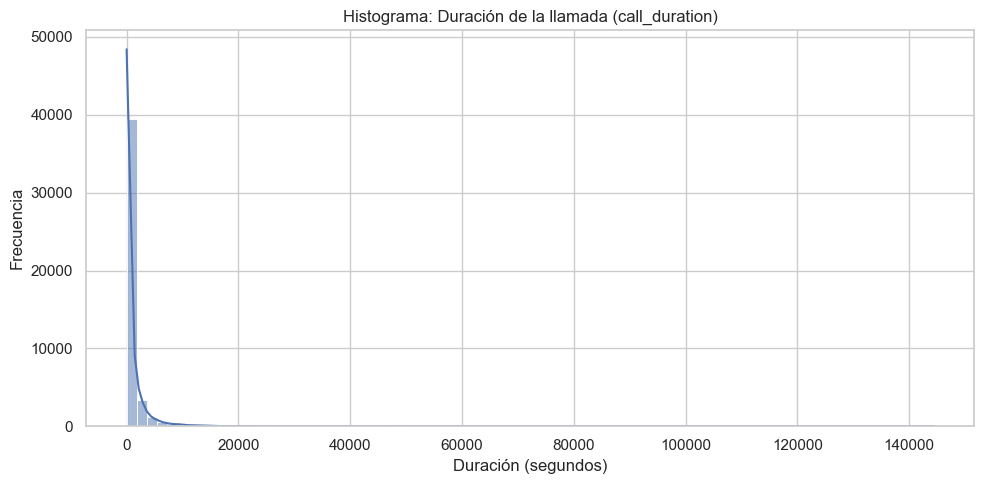

In [7]:
sns.set(style="whitegrid")

# 2.1 Histograma de la duración de la llamada (call_duration)
plt.figure(figsize=(10,5))
# usar log scale si la distribución tiene cola larga
sns.histplot(df['call_duration'].dropna(), bins=80, kde=True)
plt.title("Histograma: Duración de la llamada (call_duration)")
plt.xlabel("Duración (segundos)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

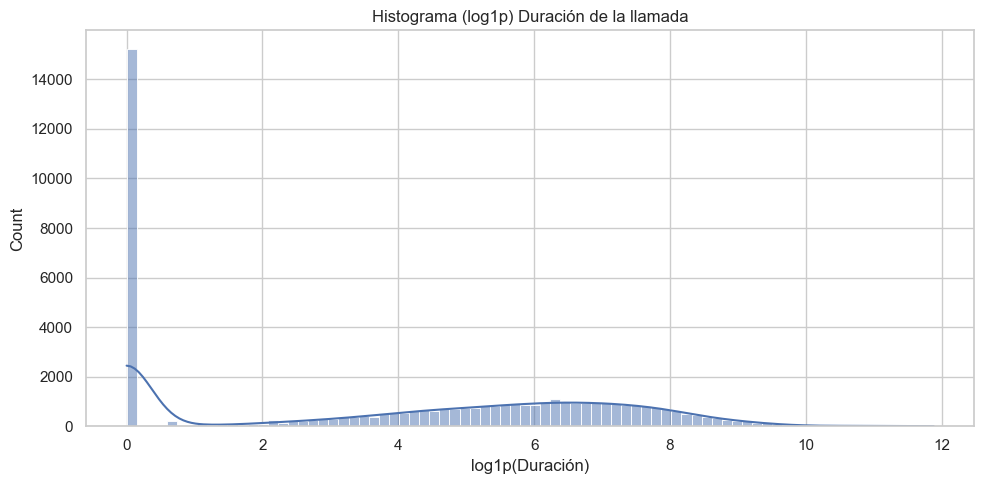

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(np.log1p(df['call_duration'].dropna()), bins=80, kde=True)
plt.title("Histograma (log1p) Duración de la llamada")
plt.xlabel("log1p(Duración)")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [6], aplicas <code>np.log1p</code> a <code>call_duration</code> para visualizar una distribución con cola larga. Esta transformación suaviza outliers y permite ver mejor el cuerpo de la distribución. Es una decisión visual y analítica acertada cuando hay sesgo positivo: ayuda a interpretar patrones que el histograma lineal puede ocultar.
</div>

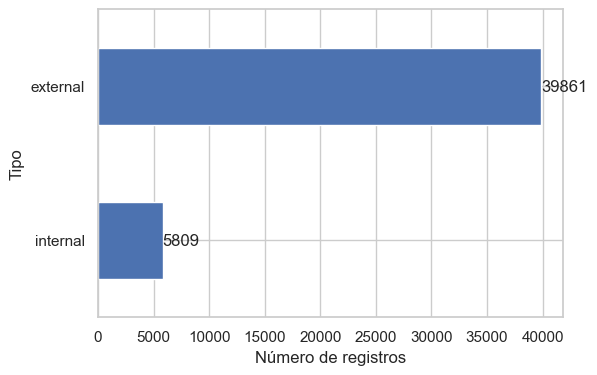

In [9]:
# 2.2 Gráfico circular: participación de llamadas internas vs externas
if 'internal' in df.columns:
    counts = df['internal'].map({1:'internal',0:'external'}).value_counts()
    ax = counts.sort_values().plot(kind='barh', figsize=(6,4))
    ax.bar_label(ax.containers[0])
    ax.set_xlabel('Número de registros')
    ax.set_ylabel('Tipo')
else:
    print("Columna 'internal' no encontrada; no se pudo dibujar el pie chart.")

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
La celda [7] usa un gráfico circular para internas vs. externas. Los pie charts dificultan comparar magnitudes cercanas, sobre todo sin valores exactos. Un gráfico de barras ordenado con etiquetas numéricas comunica mejor las diferencias. Sugerencia: <pre><code>counts = df['internal'].map({1:'internal',0:'external'}).value_counts()
ax = counts.sort_values().plot(kind='barh', figsize=(6,4))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Número de registros')
ax.set_ylabel('Tipo')
</code></pre>
Con esto, las proporciones y los totales quedan claros a simple vista.
</div>

<div class="alert alert-block alert-info">
<b>Comentario estudiante</b> <a class="tocSkip"></a>
Apliqué el código sugerido para obtener un gráfico de barras con etiquetas numéricas.

## 3. KPI's por operador

In [10]:
# Crear wait time column (total - talk time)
df['wait_time'] = df['total_call_duration'] - df['call_duration']
df['wait_time'] = df['wait_time'].clip(lower=0)

# Metricas por operador: total_calls, missed_calls, missed_rate, mean_wait, outgoing_calls, incoming_calls
df['_is_incoming'] = ((df.get('direction','').astype(str).str.lower() == 'in') & (df.get('internal',0) == 0)).astype(int)
df['_is_outgoing'] = (df.get('direction','').astype(str).str.lower() == 'out').astype(int)
agg = df.groupby('operator_id').agg(
    total_calls=('calls_count','sum'),
    missed_rows=('is_missed_call','sum'),
    mean_wait=('wait_time','mean'),
    median_wait=('wait_time','median'),
    incoming_calls=('_is_incoming','sum'),
    outgoing_calls=('_is_outgoing','sum')
).reset_index()

agg['missed_rate_row'] = agg['missed_rows'] / df.groupby('operator_id')['is_missed_call'].size().values
agg = agg.sort_values('total_calls', ascending=False)

# Filtrar operadores con pocas llamadas
agg['enough_calls'] = agg['total_calls'] >= MIN_CALLS_THRESHOLD

print("\nTop operadores por volumen:")
display(agg.head(20))


Top operadores por volumen:


,operator_id,total_calls,missed_rows,mean_wait,median_wait,incoming_calls,outgoing_calls,missed_rate_row,enough_calls
28,885876.0,66049,135,4816.241379,829.0,103,216,0.423197,True
29,885890.0,66016,110,5727.133574,4592.0,103,174,0.397112,True
583,929428.0,24572,35,5325.342857,2964.0,0,70,0.500000,True
551,925922.0,22210,33,5907.443038,3471.0,29,50,0.417722,True
317,908640.0,16699,24,3456.461538,2838.0,0,52,0.461538,True
582,929426.0,12041,35,3316.558824,2523.0,0,68,0.514706,True
1,879898.0,7974,100,450.087649,393.0,63,187,0.398406,True
847,945286.0,7919,37,2185.774648,2383.0,0,71,0.521127,True
853,945302.0,7059,40,1889.914634,1839.0,0,82,0.487805,True
108,893804.0,6570,130,269.089231,171.0,111,209,0.400000,True


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Muy bien la celda [8] al crear <code>wait_time = total_call_duration - call_duration</code> y <code>clip(lower=0)</code> para evitar tiempos negativos. Además, separar <code>_is_incoming</code> y <code>_is_outgoing</code> facilita KPIs por dirección. Este diseño de métricas operativas es claro y útil para el diagnóstico posterior.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la agregación de la celda [8], <code>total_calls</code> se calcula como el conteo de filas (<code>count</code>) aunque existe la columna <code>calls_count</code>. Esto puede subcontar si una fila representa múltiples llamadas. Si la granularidad es "varias llamadas por fila", conviene sumar <code>calls_count</code> para los totales y, cuando sea semánticamente correcto, ponderar tasas. Consecuencia: tasas como <code>missed_rate</code> podrían no reflejar el volumen real. Acción concreta (si los significados lo permiten): <pre><code>agg = df.groupby('operator_id').agg(
    total_calls=('calls_count','sum'),
    missed_rows=('is_missed_call','sum'),
    mean_wait=('wait_time','mean'),
    median_wait=('wait_time','median'),
    incoming_calls=('_is_incoming','sum'),
    outgoing_calls=('_is_outgoing','sum')
).reset_index()
# Opcional: tasa por fila vs. tasa ponderada por llamadas
agg['missed_rate_row'] = agg['missed_rows'] / df.groupby('operator_id')['is_missed_call'].size().values
# Solo si una fila indica "todas las llamadas perdidas":
# agg['missed_rate_weighted'] = (df.assign(missed_weight=df['is_missed_call']*df['calls_count'])
#                               .groupby('operator_id')['missed_weight'].sum() / agg['total_calls'])
</code></pre>
</div>

<div class="alert alert-block alert-info">
<b>Comentario estudiante</b> <a class="tocSkip"></a>
Apliqué el código sugerido para obtener métricas por operador y crear la columna <code>missed_rate_row</code> la cual indica la proporción de llamadas perdidas por operador.

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En el top de la celda [8] aparece <code>operator_id = 'unknown'</code> con 8172 registros y <code>missed_rate ≈ 0.985</code>. Incluir un grupo de "desconocidos" junto a operadores reales distorsiona comparaciones y tests. La consecuencia es que benchmarks y promedios de pares quedan sesgados. Acción: excluye <code>'unknown'</code> de KPIs y pruebas, o trátalo como categoría aparte: <pre><code>df_valid = df[df['operator_id']!='unknown'].copy()
# usar df_valid en aggregations y tests
</code></pre>
Esto hace más justas las comparaciones entre operadores reales.
</div>

## 4. Score compuesto para priorizar ineficiencia

In [11]:
# Normalizar métricas (robust scaling via rank or min-max)
# Calcularemos rangos de percentiles para que las métricas sean robustas ante valores atípicos.
agg['missed_rank'] = agg['missed_rate_row'].rank(pct=True)
# mean wait: cuanto mas alto es peor => rank by mean_wait
agg['wait_rank'] = agg['mean_wait'].rank(pct=True)
# low outgoing: Poco es malo -> Invertimos el rango de salida
agg['outgoing_rank'] = (1 - (agg['outgoing_calls'].rank(pct=True)))

# Algunos operadores pueden tener cero salidas (ok)
# Compose score (0..1) higher => worse
agg['ineff_score'] = (
    WEIGHT_MISSED_RATE * agg['missed_rank']
    + WEIGHT_MEAN_WAIT * agg['wait_rank']
    + WEIGHT_LOW_OUTGOING * agg['outgoing_rank']
)

# Considerar solamente operadores con suficiente ranking de llamadas; aun asi mostrar los otros separadamente
ranked = agg[agg['enough_calls']].sort_values('ineff_score', ascending=False).reset_index(drop=True)
print("\nTop 20 operadores por score de ineficiencia (solo con enough_calls=True):")
display(ranked[['operator_id','total_calls','missed_rate_row','mean_wait','outgoing_calls','ineff_score']].head(20))


Top 20 operadores por score de ineficiencia (solo con enough_calls=True):


,operator_id,total_calls,missed_rate_row,mean_wait,outgoing_calls,ineff_score
0,952466.0,134,0.750000,546.750000,4,0.878846
1,928518.0,337,0.571429,1106.571429,7,0.858471
2,938080.0,742,0.555556,1876.222222,9,0.858333
3,937650.0,91,0.833333,277.166667,6,0.850412
4,965544.0,1277,0.538462,1928.384615,13,0.841071
5,896386.0,76,0.500000,925.000000,2,0.838370
6,938078.0,856,0.538462,1566.307692,13,0.837500
7,919188.0,864,0.538462,1453.461538,13,0.836126
8,953458.0,61,0.714286,170.714286,7,0.821062
9,938070.0,671,0.500000,1745.250000,8,0.819689


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La celda [9] construye un score compuesto con <i>percent ranks</i>, lo cual es resistente a outliers y permite combinar métricas en escalas diferentes. Además, ponderas explícitamente (missed_rate, mean_wait, outgoing_calls invertido), lo que refleja priorización de negocio. Es una forma sólida de ordenar ineficiencia sin quedar rehén de valores extremos.
</div>

## 5. Pruebas estadísticas por operador


In [12]:
# 5.1 Test para tasa de llamadas perdidas (proporciones) 
# Comparar missed_rate vs peer group's missed_rate (peers = ttodos los operadores excluyendo este)
tests = []
operators_to_test = ranked['operator_id'].tolist()  # test top operators by score
for op in operators_to_test:
    row = agg[agg['operator_id']==op].iloc[0]
    succ = int(row['missed_rows'])
    nobs = int(row['total_calls'])
    # peers
    peers = agg[agg['operator_id'] != op]
    succ_peers = int(peers['missed_rows'].sum())
    nobs_peers = int(peers['total_calls'].sum()) 
# proportions_ztest: prueba si la tasa de omisión del operador es mayor que la tasa de omisión de sus pares 
# los conteos son [op_succ, peers_succ]; matriz de nobs en consecuencia 
    try:
        stat, pval = proportions_ztest([succ, succ_peers], [nobs, nobs_peers], alternative='larger')
    except Exception as e:
        stat, pval = np.nan, np.nan
    tests.append({
        'operator_id': op,
        'succ': succ,
        'nobs': nobs,
        'succ_peers': succ_peers,
        'nobs_peers': nobs_peers,
        'z_stat': stat,
        'pval': pval,
        'missed_rate': row['missed_rate_row']
    })

tests_df = pd.DataFrame(tests)

# Correccion de multiplicidad (Benjamini-Hochberg FDR)

if not tests_df['pval'].isnull().all():
    rej, pvals_corrected, _, _ = multipletests(tests_df['pval'].fillna(1).values, alpha=ALPHA, method='fdr_bh')
    tests_df['pval_adj'] = pvals_corrected
    tests_df['reject_null_fdr'] = rej
else:
    tests_df['pval_adj'] = np.nan
    tests_df['reject_null_fdr'] = False

tests_df = tests_df.sort_values('pval').reset_index(drop=True)
print(tests_df)

    operator_id  succ   nobs  succ_peers  nobs_peers     z_stat          pval  \
0      896016.0    61    377       15457      772662  19.625632  4.670450e-86   
1      900492.0    50    276       15468      772763  19.084222  1.707622e-81   
2      924960.0    49    303       15469      772736  17.582683  1.671855e-69   
3      891416.0    94    966       15424      772073  17.126059  4.743350e-66   
4      912722.0    70    607       15448      772432  16.737997  3.464043e-63   
..          ...   ...    ...         ...         ...        ...           ...   
595    908640.0    24  16699       15494      756340 -17.359816  1.000000e+00   
596    885890.0   110  66016       15408      707023 -35.261079  1.000000e+00   
597    929426.0    35  12041       15483      760998 -13.537174  1.000000e+00   
598    945286.0    37   7919       15481      765120  -9.822596  1.000000e+00   
599    885876.0   135  66049       15383      706990 -34.547060  1.000000e+00   

     missed_rate      pval_

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [10], usas <code>proportions_ztest</code> con <code>alternative='larger'</code> para contrastar tasas del operador frente a sus pares y aplicas corrección FDR Benjamini–Hochberg. Es una combinación adecuada: hipótesis direccional coherente con el objetivo (peor que pares) y control del error por múltiples comparaciones. Muy buen rigor estadístico.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
Aún con la celda [10] bien planteada, recuerda que los "pares" incluyen a <code>'unknown'</code> y a operadores con muy poco tráfico. Esto puede inflar o deflactar <i>p-values</i>. Si ya filtraste <code>ranked</code> por <code>enough_calls</code>, conviene que los pares también cumplan ese umbral y que <code>'unknown'</code> quede fuera. Ganancia: comparaciones más estables y justas. Acción: <pre><code>valid_ops = agg[(agg['enough_calls']) & (agg['operator_id']!='unknown')]['operator_id']
for op in operators_to_test:
    peers = agg[agg['operator_id'].isin(valid_ops) & (agg['operator_id']!=op)]
    # ... calcular succ_peers y nobs_peers sobre peers válidos
</code></pre>
</div>

In [13]:
# 5.2 Test para tiempo de espera: comparar mediana de operador vs peers (Mann-Whitney)
wait_tests = []
for op in operators_to_test:
    op_waits = df[df['operator_id']==op]['wait_time'].dropna()
    peer_waits = df[df['operator_id']!=op]['wait_time'].dropna()
    if len(op_waits) >= 10 and len(peer_waits) >= 10: # require sample size
        try:
            u_stat, p_u = stats.mannwhitneyu(op_waits, peer_waits, alternative='greater')  # alternative: operator > peers
        except Exception as e:
            u_stat, p_u = np.nan, np.nan
    else:
        u_stat, p_u = np.nan, np.nan
    wait_tests.append({'operator_id': op, 'u_stat': u_stat, 'pval': p_u, 'mean_wait_op': op_waits.mean(), 'mean_wait_peers': peer_waits.mean()})
wait_df = pd.DataFrame(wait_tests) 
# ajuste p-values
if not wait_df['pval'].isnull().all():
    rej_w, pvals_w_adj, _, _ = multipletests(wait_df['pval'].fillna(1).values, alpha=ALPHA, method='fdr_bh')
    wait_df['pval_adj'] = pvals_w_adj
    wait_df['reject_null_fdr'] = rej_w
else:
    wait_df['pval_adj'] = np.nan
    wait_df['reject_null_fdr'] = False

print(wait_df)

    operator_id     u_stat          pval  mean_wait_op  mean_wait_peers  \
0      952466.0        NaN           NaN    546.750000       312.356165   
1      928518.0        NaN           NaN   1106.571429       312.255080   
2      938080.0        NaN           NaN   1876.222222       312.068831   
3      937650.0        NaN           NaN    277.166667       312.381288   
4      965544.0   527332.0  6.604622e-07   1928.384615       311.917142   
..          ...        ...           ...           ...              ...   
595    908082.0   265939.0  1.000000e+00     13.424242       312.592555   
596    900614.0   342752.0  1.000000e+00     14.658537       312.643831   
597    907182.0  1241748.0  1.000000e+00     19.206349       313.186672   
598    907994.0   817812.0  1.000000e+00     16.632184       312.940385   
599    907952.0  1066535.5  1.000000e+00     16.683761       313.135137   

     pval_adj  reject_null_fdr  
0    1.000000            False  
1    1.000000            False  


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La celda [11] utiliza Mann–Whitney U con <code>alternative='greater'</code> para comparar tiempos de espera sin asumir normalidad, e incluye ajuste FDR. Además, impones tamaño mínimo de muestra (<code>>= 10</code>). Esta selección es prudente cuando hay asimetría y colas largas en tiempos; evita conclusiones engañosas por supuestos no cumplidos.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [11], reportas medias (<code>mean_wait_op</code>, <code>mean_wait_peers</code>) aunque la prueba contrasta distribuciones (más sensible a medianas/rangos). Esto puede dificultar la interpretación. Para una foto más completa, añade una medida de efecto y medianas: diferencia de medianas y correlación biserial por rangos (derivada de U). Esto aclara "cuánto" peor es un operador, no solo si es significativo. Acción: <pre><code>import numpy as np
from scipy import stats
n1, n2 = len(op_waits), len(peer_waits)
rbc = 1 - 2* (u_stat / (n1*n2))  # rank-biserial (signo según alternativa)
median_diff = np.median(op_waits) - np.median(peer_waits)
</code></pre>
Incluye <code>median_diff</code> y <code>rbc</code> en <code>wait_df</code> para enriquecer el reporte.
</div>

## 6) Generar reporte final por operador con banderas y recomendaciones


In [14]:
report = ranked.merge(tests_df[['operator_id','pval','pval_adj','reject_null_fdr']], on='operator_id', how='left')
report = report.merge(wait_df[['operator_id','pval','pval_adj','reject_null_fdr']].rename(columns={'pval':'wait_pval','pval_adj':'wait_pval_adj','reject_null_fdr':'wait_reject'}), on='operator_id', how='left')

# Flags logic:
# - flagged_missed si la tasa de omisión pval_adj < ALPHA (tasa de omisión significativamente más alta)
# - flagged_wait if wait_reject True
report['flag_missed'] = report['reject_null_fdr'] = report['reject_null_fdr'].fillna(False)
report['flag_missed'] = report['reject_null_fdr'] | (report['missed_rate_row'] >= agg['missed_rate_row'].quantile(0.90))
report['flag_wait'] = report['wait_reject'].fillna(False) | (report['mean_wait'] >= agg['mean_wait'].quantile(0.90))

# Priority label
def priority_label(row):
    score = 0
    if row['flag_missed']: score += 2
    if row['flag_wait']: score += 2
    if row['outgoing_calls'] < np.percentile(agg['outgoing_calls'], 25): score += 1
    if row['ineff_score'] >= agg['ineff_score'].quantile(0.90): score += 1
    if score >= 4: return "HIGH"
    if score >= 2: return "MEDIUM"
    return "LOW"

report['priority'] = report.apply(priority_label, axis=1)

print(report)


    operator_id  total_calls  missed_rows    mean_wait  median_wait  \
0      952466.0          134            3   546.750000        708.0   
1      928518.0          337            4  1106.571429       1156.0   
2      938080.0          742            5  1876.222222       1779.0   
3      937650.0           91            5   277.166667         31.0   
4      965544.0         1277            7  1928.384615       2193.0   
..          ...          ...          ...          ...          ...   
595    908082.0           51            2    13.424242         12.0   
596    900614.0           66            5    14.658537         10.0   
597    907182.0          339           26    19.206349         14.0   
598    907994.0          164           17    16.632184         16.0   
599    907952.0          245           21    16.683761         15.0   

     incoming_calls  outgoing_calls  missed_rate_row  enough_calls  \
0                 0               4         0.750000          True   
1      

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [12], la línea <code>report['flag_missed'] = report['reject_null_fdr'] = report['reject_null_fdr'].fillna(False)</code> hace una asignación encadenada que puede ser confusa y arriesga efectos no deseados. Mejor asignar por separado y de forma explícita. Además, asegúrate de que los cuantiles de referencia se calculen sobre operadores válidos (excluyendo <code>'unknown'</code> si decidiste apartarlo). Acción: <pre><code>report['reject_null_fdr'] = report['reject_null_fdr'].fillna(False)
report['flag_missed'] = report['reject_null_fdr'] | (report['missed_rate'] >= agg.loc[agg['operator_id']!='unknown', 'missed_rate'].quantile(0.90))
report['flag_wait'] = report['wait_reject'].fillna(False) | (report['mean_wait'] >= agg.loc[agg['operator_id']!='unknown', 'mean_wait'].quantile(0.90))
</code></pre>
Con esto, las banderas quedan claras y consistentes con tu criterio.
</div>

## 7) Visualizaciones de apoyo (top offenders)

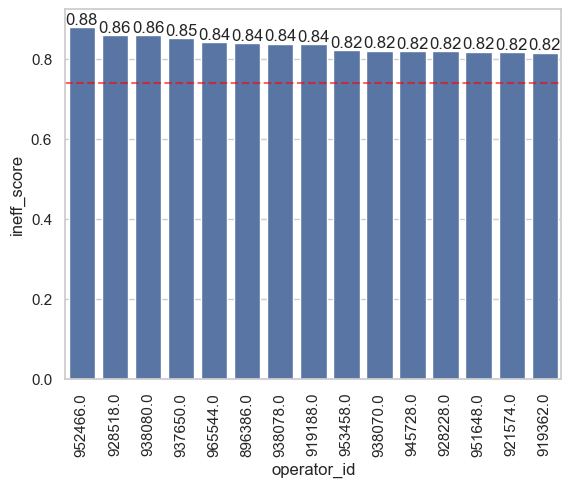

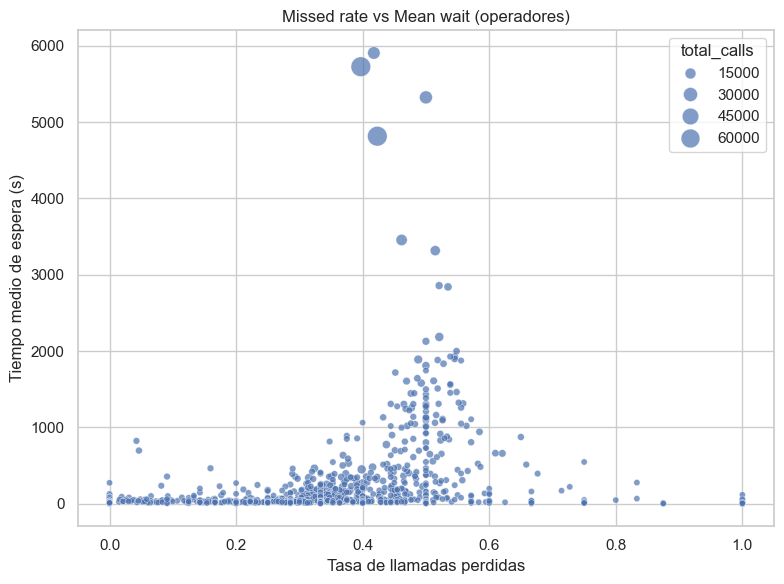

In [15]:
topN = 15
top_offenders = report.head(topN)

top_offenders = top_offenders.assign(operator_id=top_offenders['operator_id'].astype(str))
sns.barplot(data=top_offenders, x='operator_id', y='ineff_score')
plt.xticks(rotation=90)
# Añadir línea de referencia (p90)
plt.axhline(agg['ineff_score'].quantile(0.9), ls='--', c='red', alpha=0.6)
# Opcional: anotar barras
for c in plt.gca().containers:
    plt.bar_label(c, fmt='%.2f')

# Scatter missed_rate vs mean_wait (all operators)
plt.figure(figsize=(8,6))
sns.scatterplot(data=agg, x='missed_rate_row', y='mean_wait', size='total_calls', sizes=(20,200), alpha=0.7)
plt.xlabel("Tasa de llamadas perdidas")
plt.ylabel("Tiempo medio de espera (s)")
plt.title("Missed rate vs Mean wait (operadores)")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En las visualizaciones de la celda [13], <code>operator_id</code> aparece como flotante (p.ej., <code>902748.0</code>), lo que dificulta leer el eje y puede provocar notación científica. Formatearlo como <code>string</code> y añadir etiquetas o referencias a los percentiles mejorará la lectura. Acción: <pre><code>top_offenders = top_offenders.assign(operator_id=top_offenders['operator_id'].astype(str))
sns.barplot(data=top_offenders, x='operator_id', y='ineff_score')
# Añadir línea de referencia (p90)
plt.axhline(agg['ineff_score'].quantile(0.9), ls='--', c='red', alpha=0.6)
# Opcional: anotar barras
for c in plt.gca().containers:
    plt.bar_label(c, fmt='%.2f')
</code></pre>
Esto ayuda a identificar rápidamente a los operadores más críticos y a contextualizar su score.
</div>

<div class="alert alert-block alert-info">
<b>Comentario estudiante</b> <a class="tocSkip"></a>
Apliqué el código sugerido para mejorar la calidad del primer gráfico donde se ve claramente a los operadores más críticos con su score.

## 8) Recomendaciones automáticas

In [16]:
high_priority = report[report['priority']=='HIGH']
print("\n==== RECOMENDACIONES AUTOMÁTICAS (resumen) ====")
if not high_priority.empty:
    for _, r in high_priority.iterrows():
        print(f"\nOperator {r['operator_id']} (PRIORITY: HIGH)")
        print(f" - Total calls: {int(r['total_calls'])}, Missed rate: {r['missed_rate_row']:.2%}, Mean wait: {r['mean_wait']:.1f}s")
        print(" - Recomendado: Coaching urgente, revisar horarios/picos, revisar colas/IVR, considerar reasignación temporal de tráfico.")
else:
    print("No se identificaron operadores HIGH priority con los criterios actuales.")


==== RECOMENDACIONES AUTOMÁTICAS (resumen) ====

Operator 952466.0 (PRIORITY: HIGH)
 - Total calls: 134, Missed rate: 75.00%, Mean wait: 546.8s
 - Recomendado: Coaching urgente, revisar horarios/picos, revisar colas/IVR, considerar reasignación temporal de tráfico.

Operator 928518.0 (PRIORITY: HIGH)
 - Total calls: 337, Missed rate: 57.14%, Mean wait: 1106.6s
 - Recomendado: Coaching urgente, revisar horarios/picos, revisar colas/IVR, considerar reasignación temporal de tráfico.

Operator 938080.0 (PRIORITY: HIGH)
 - Total calls: 742, Missed rate: 55.56%, Mean wait: 1876.2s
 - Recomendado: Coaching urgente, revisar horarios/picos, revisar colas/IVR, considerar reasignación temporal de tráfico.

Operator 919362.0 (PRIORITY: HIGH)
 - Total calls: 2546, Missed rate: 54.84%, Mean wait: 1999.7s
 - Recomendado: Coaching urgente, revisar horarios/picos, revisar colas/IVR, considerar reasignación temporal de tráfico.

Operator 919382.0 (PRIORITY: HIGH)
 - Total calls: 1827, Missed rate: 55.5

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [14], generas un resumen claro para los operadores de prioridad alta, incluyendo volumen, tasa de perdidas y tiempo medio de espera, con una recomendación accionable. Este cierre operativo conecta el análisis con decisiones de negocio (coaching, horarios, colas/IVR), que es justo el objetivo de un reporte analítico. Muy buen puente entre estadística y acción.
</div>

<div class="alert alert-block alert-info">
<b>Comentario estudiante</b> <a class="tocSkip"></a>
Hola revisor! He aquí el pipeline del workflow que se propuso en el la primera tarea del proyecto. Sé que todavía me falta por entregar los slides y el dashboard pero primero quiero asegurarme que el código esta correcto para porceder con los demás entregables. Gracias por tu apoyo y atención en la revisión de esta tarea. Saludos!

<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Carlos! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
• Parametrizaste pesos, umbrales y alfa desde el inicio, facilitando escenarios y reproducibilidad.<br>
• Verificaste el estado del dataset con <code>info()</code> y listado de columnas antes de transformar.<br>
• Normalizaste tipos de forma robusta (parseo de fechas con zona horaria y coerción numérica segura).<br>
• Estandarizaste variables categóricas como <code>is_missed_call</code> e <code>internal</code> contemplando múltiples formatos.<br>
• Definiste <code>wait_time</code> y evitaste valores negativos con <code>clip</code>, lo que sanea la métrica.<br>
• Diferenciaste llamadas entrantes/salientes para enriquecer los KPIs por dirección.<br>
• Usaste <i>percent ranks</i> y ponderaciones para construir un score robusto a outliers.<br>
• Seleccionaste pruebas adecuadas: Z-test para proporciones y Mann–Whitney para tiempos no normales.<br>
• Aplicaste control de multiplicidad con Benjamini–Hochberg, elevando el rigor de las conclusiones.<br>
• Impusiste umbrales mínimos de muestra para evitar inestabilidad en las comparaciones.<br>
• Completaste un pipeline que integra KPIs, score, tests y un reporte unificado por operador.<br>
• Incorporaste visualizaciones útiles (histogramas con KDE, log-transform, scatter con tamaño por volumen).<br>
• Diseñaste banderas y una etiqueta de prioridad que combinan evidencia estadística y reglas de negocio.<br>
• Cerraste con recomendaciones automáticas concretas para casos de alta prioridad.<br>
• Mantienes el código legible y modular, con pasos bien separados (carga, EDA, KPIs, tests, reporte).<br>
• Consideraste medidas robustas (mediana de espera) además de promedios, mostrando criterio analítico.<br>
<b>Quedo a la espera de las diapositivas y el tablero.</b>
<br>
¡Felicidades!
</div>